In [2]:
import jax.numpy as np
from jax import jit
from discopy import Tensor
Tensor.np = np

import discopy

In [29]:
#******************************************
# Generate your corpus
#******************************************
# sentences can be of the `word1 word2 word3 ...`
# if you are generating the diagrams using templates
# then you may want to consider adding POS tags (N, V, Adj) for each word
# labels should be of the form [0,1] or [1,0] for binary classification

# TODO make sentences
## Basketball game
train_sentences = ['Bulls play Hornets', 'Bulls beat Hornets', 'Bulls from Charlotte', 'Bulls in Chicago', 
                   'Hornets from Charlotte', 'Bulls wear green', 'Charlotte in Illinois', 'Chicago in Illinois', 
                   'Bulls lost championships','Hornets attended championships']
dev_sentences = ['Bulls wear red', 'Hornets wear green','Hornets in Charlotte','Hornets beat Bulls','Hornets won championships']
test_sentences = ['Hornets forfeit Bulls', 'Bulls represent Chicago', 'Hornets scrimmaged Bulls', 'Bulls in Illinois', 
                  'Hornets in Illinois', 'Hornets in Carolina', 'Bulls in Carolina', 'Bulls wear red', 
                  'Bulls won championships', 'Chicago won championships', 'Illinois won championships']

# TODO make labels
train_labels = [[1,0],[1,0],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[0,1],[1,0]]
dev_labels = [[1,0],[1,0],[1,0],[0,1],[0,1]]
test_labels = [[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[1,0],[1,0],[1,0]]

train_labels = np.array(train_labels)
dev_labels = np.array(dev_labels)
test_labels = np.array(test_labels)

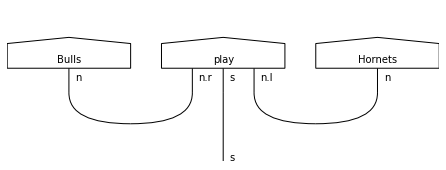

In [141]:
#******************************************
# Generate your diagrams
#******************************************
# TODO generate the DisCoCat diagrams for your corpus. There are 2 options:
# 1. Follow a few fixed templates (N V N, N V Adj N, ...)
# 2. Use the online tool to generate diagrams. 
# If you are using the online tool, consider writing a script.

# Suggestion: print out some of your DisCoCat diagrams using
# `grammar.draw` to check that they make sense.

from discopy import Word, Ty, Cup, Id, grammar, Ob
from sympy.abc import phi

n, s = Ty('n'), Ty('s')

# example of how to make your template:
# then you use your pos tags to determine which template to use
def NVN_example(w0, w1, w2):
    words = Word(w0, n) @ Word(w1, n.r @ s @ n.l) @ Word(w2, n)
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

    return words >> cups

# TODO implement sentence2diagram
sentence2diagram = lambda a : NVN_example(a.split()[0], a.split()[1], a.split()[2])

train_diagrams = [sentence2diagram(s) for s in train_sentences]
dev_diagrams = [sentence2diagram(s) for s in dev_sentences]
test_diagrams = [sentence2diagram(s) for s in test_sentences]

# from discopy import Word, Ty, Cup, Id, grammar
# from sympy.abc import phi

# n, s = Ty('n'), Ty('s')

# # example of how to make your template:
# # then you use your pos tags to determine which template to use
# def NVN_example(w0, w1, w2):
#     words = Word(w0, n) @ Word(w1, n.r @ s @ n.l) @ Word(w2, n)
#     cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

#     return words >> cups

grammar.draw(NVN_example('Bulls', 'play', 'Hornets'))

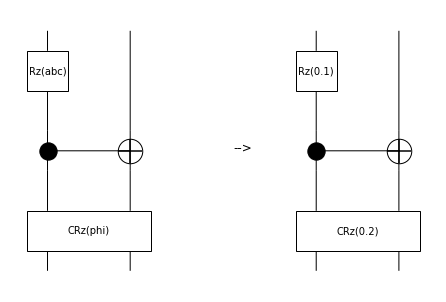

In [142]:
#******************************************
# Generate your circuits
#******************************************
# TODO: Implement your own functorial ansatz conversion!
# The `qnlp-tutorial` has some code on this.
# https://discopy.readthedocs.io/en/main/notebooks/qnlp-tutorial.html
# You may also find discopy's `IQPansatz` function useful.

# Suggestion: Draw some DisCoCat diagrams alongside their circuit diagrams
# and compare them

# TODO implement diagram2circuit
# diagram2circuit = None

from discopy.quantum import circuit, qubit, sqrt, X, CX, H, Ket, Id, Rz, CRz, Rx
from sympy.abc import symbols, phi

sym = symbols("abc")
# circ = Rz(sym) @ Id(1) >> CX >> CRz(phi)
# circ.lambdify(sym, phi)(0.1, 0.2)
# circ = sqrt(2) @ Ket(0, 0) >> H @ Rz(sym) >> CRz(phi)
circ = Ket(0, 0) >> H @ sqrt(2) @ Rx(sym) >> CX
# circ.lambdify(sym, phi)(0.1, 0.2)
   
# ob={s: Ty(), n: qubit}

# ar = lambda params: {
#     Word('Bulls', n): Ket(0),
#     Word('Chicago', n): Ket(0),
#     Word('Illinois', n): Ket(0),
#     Word('championships', n): Ket(0),
#     Word('red', n): Ket(0),
#     Word('Hornets', n): Ket(1),
#     Word('Charlotte', n): Ket(1),
#     Word('green', n): Ket(1),
#     Word('Carolina', n): Ket(1),
#     Word('play', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['play']),
#     Word('beat', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['beat']), 
#     Word('from', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['from']), 
#     Word('in', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['in']), 
#     Word('wear', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['wear']), 
#     Word('lost', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['lost']), 
#     Word('attended', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['attended']), 
#     Word('won', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['won']), 
#     Word('forfeit', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['forfeit']), 
#     Word('represent', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['represent']), 
#     Word('scrimmaged', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): verb_ansatz(params['scrimmaged'])
# }
    
# diagram2circuit = lambda params: CircuitFunctor(ob, ar(params))

diagram2circuit = circuit.Functor(
    ob={s: Ty(), n: qubit},
    ar={Word('Bulls', n): Ket(0),
        Word('Chicago', n): Ket(0),
        Word('Illinois', n): Ket(0),
        Word('championships', n): Ket(0),
        Word('red', n): Ket(0),
        Word('Hornets', n): Ket(1),
        Word('Charlotte', n): Ket(1),
        Word('green', n): Ket(1),
        Word('Carolina', n): Ket(1),
        Word('play', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ,
        Word('beat', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ, 
        Word('from', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ, 
        Word('in', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ, 
        Word('wear', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ, 
        Word('lost', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ, 
        Word('attended', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ, 
        Word('won', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ, 
        Word('forfeit', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ, 
        Word('represent', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ, 
        Word('scrimmaged', Ty(Ob('n', z=1), 's', Ob('n', z=-1))): circ})

params0 = {'play': 0.5, 'beat':0.3, 'from':0.6, 'in':0.9, 'wear':0.2, 'lost':0.1, 'attended':0.4, 'won':1.0, 
           'forfeit':0.3, 'represent':0.2, 'scrimmaged':0.1}

# train_circuits = [diagram2circuit(params0)(d) for d in train_diagrams]
# dev_circuits = [diagram2circuit(params0)(d) for d in dev_diagrams]
# test_circuits = [diagram2circuit(params0)(d) for d in test_diagrams]
train_circuits = [diagram2circuit(d) for d in train_diagrams]
dev_circuits = [diagram2circuit(d) for d in dev_diagrams]
test_circuits = [diagram2circuit(d) for d in test_diagrams]

# You can define parameterised circuits in DisCoPy
# using sympy variables, then substituting them using `lambdify`
from discopy import drawing
from discopy.quantum import Id, Rz, CX, CRz
from sympy.abc import symbols, phi


sym = symbols("abc")
circ = Rz(sym) @ Id(1) >> CX >> CRz(phi)
drawing.equation(circ, circ.lambdify(sym, phi)(0.1, 0.2), symbol='-->')

In [143]:
# These imports will come in handy when you want to run
# backend simulations.

# from qiskit import IBMQ
# from pytket.extensions.qiskit import AerBackend, IBMQBackend, IBMQEmulatorBackend

In [144]:
#******************************************
# Counting parameters in your model
#******************************************
from sympy import default_sort_key
circuits = train_circuits + dev_circuits + test_circuits

# Make sure you sort your symbols as they are returned as a set.
parameters = sorted({
    s for circ in circuits for s in circ.free_symbols
}, key=default_sort_key)

In [145]:
circuits[0]

Circuit(dom=Ty(), cod=Ty(), boxes=[Ket(0), Ket(0, 0), H, sqrt(2), Rx(abc), CX, Ket(1), CX, H, sqrt(2), Bra(0, 0), CX, H, sqrt(2), Bra(0, 0)], offsets=[0, 1, 1, 2, 2, 1, 3, 0, 0, 1, 0, 0, 0, 1, 0])

In [146]:
parameters

[abc]

In [147]:
def normalise(predicts):
    # apply smoothing to predicts
    predicts = np.abs(predicts - 1e-9)
    predicts = predicts / predicts.sum()
    return predicts

def BCE_loss(predicts, labels):
    cross_entropies = np.sum(labels * np.log2(predicts))
    cost = -1/len(labels) * np.sum(cross_entropies)

    return cost

In [148]:
def make_pred_fn(circuits):
    def pred_fn(params):
        predictions = np.array([
            normalise(np.abs(c.lambdify(*parameters)(*params).eval().array))
            for c in circuits
        ])
#         for c in circuits:
# #             print(params)
#             print(c.lambdify(*parameters)(*params))
#             return (np.abs(c.lambdify(*parameters)(*params).eval().array))
        return predictions

    return pred_fn

In [149]:
train_pred_fn = jit(make_pred_fn(train_circuits))
dev_pred_fn = jit(make_pred_fn(dev_circuits))
test_pred_fn = jit(make_pred_fn(test_circuits))

import numpy as onp
# onp.random.seed(0)

x0 = np.array(onp.random.random(len(parameters)))
print("Performing Just-In-Time compilation, this may take a while...")
train_pred_fn(x0)
dev_pred_fn(x0)

Performing Just-In-Time compilation, this may take a while...


DeviceArray([[1.],
             [1.],
             [1.],
             [1.],
             [1.]], dtype=float32)

In [9]:
train_pred_fn = jit(make_pred_fn(train_circuits))
dev_pred_fn = jit(make_pred_fn(dev_circuits))
test_pred_fn = jit(make_pred_fn(test_circuits))

import numpy as onp
# onp.random.seed(0)

x0 = np.array(onp.random.random(len(parameters)))
print("Performing Just-In-Time compilation, this may take a while...")
train_pred_fn(x0)
dev_pred_fn(x0)

Performing Just-In-Time compilation, this may take a while...


DeviceArray([[0.59450185, 0.40549812],
             [0.04066788, 0.9593321 ],
             [0.1270783 , 0.8729217 ],
             ...,
             [0.30980638, 0.6901936 ],
             [0.47308612, 0.5269139 ],
             [0.396312  , 0.603688  ]], dtype=float32)

In [150]:
def make_cost_fn(pred_fn, labels):
    costs = []
    accs = []
    params_list = []
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = BCE_loss(predictions, labels)
        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2
        costs.append(cost)
        accs.append(acc)
        params_list.append(params)

        return cost

    return cost_fn, costs, accs, params_list

In [151]:
# Rerun this cell onwards, so you can reuse the JITed prediction functions

train_cost_fn, train_costs, train_accs, spsa_params = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs, callback_params = make_cost_fn(dev_pred_fn, dev_labels)
test_cost_fn, test_costs, test_accs, _ = make_cost_fn(test_pred_fn, test_labels)

In [152]:
from noisyopt import minimizeSPSA
minimizeSPSA(train_cost_fn, x0=x0, a=0.13, c=0.1, niter=2000, callback=dev_cost_fn)

     fun: DeviceArray(-0., dtype=float32)
 message: 'terminated after reaching max number of iterations'
    nfev: 4000
     nit: 2000
 success: True
       x: DeviceArray([0.8459638], dtype=float32)

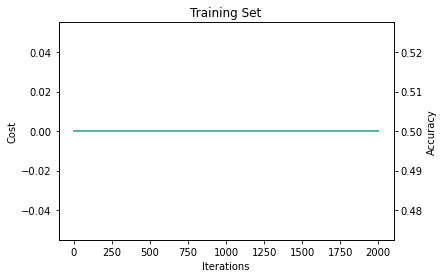

In [155]:
import matplotlib.pylab as plt
fig, ax1 = plt.subplots()
ax1.plot(train_costs[::2], color='#54436B')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Training Set')

ax2 = ax1.twinx()
ax2.plot(train_accs[::2], color='#50CB93')
ax2.set_ylabel('Accuracy')
plt.show()

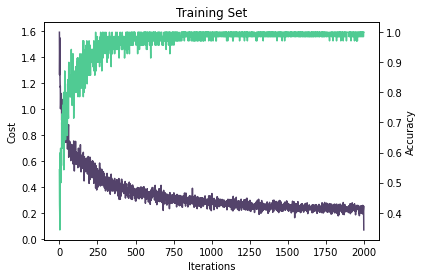

In [15]:
import matplotlib.pylab as plt
fig, ax1 = plt.subplots()
ax1.plot(train_costs[::2], color='#54436B')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Training Set')

ax2 = ax1.twinx()
ax2.plot(train_accs[::2], color='#50CB93')
ax2.set_ylabel('Accuracy')
plt.show()

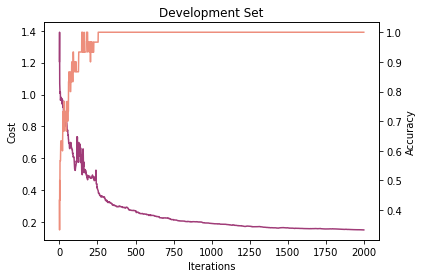

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(dev_costs, color='#A03C78')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Development Set')

ax2 = ax1.twinx()
ax2.plot(dev_accs, color='#ED8E7C')
ax2.set_ylabel('Accuracy')
plt.show()

In [16]:
# when you are happy with the development set results
# run your model on the testing set

# for p in callback_params:
#     test_cost_fn(p)

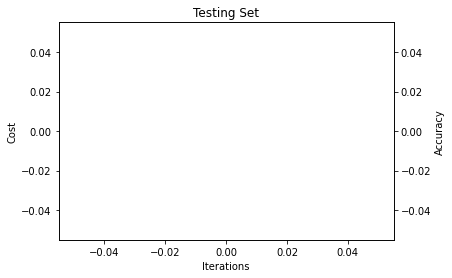

In [17]:
fig, ax1 = plt.subplots()
ax1.plot(test_costs, color='#7C83FD')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Testing Set')

ax2 = ax1.twinx()
ax2.plot(test_accs, color='#96BAFF')
ax2.set_ylabel('Accuracy')
plt.show()